# FC2: Reinforcement Learning

In [1]:
import sys
!pip install tensorflow
!pip install gymnasium 
!pip install pygame
assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier. We will also display some Matplotlib animations, and there are several possible options to do that: we will use the Javascript option.

In [3]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

And let's create the `images/rl` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


Let's install the Gymnasium library, which provides many environments for Reinforcement Learning. We'll also install the extra libraries needed for classic control environments (including CartPole, which we will use shortly), as well as for Box2D and Atari environments, which are needed for the exercises.

**Important notes:**
* OpenAI has handed over the maintenance and developmnent of the Gym library to the Farama foundation (see the [announcement](https://farama.org/Announcing-The-Farama-Foundation)), and the library was renamed to Gymnasium. It's a drop-in replacement for OpenAI Gym: you can just install `gymnasium` instead of `gym`, and `import gymnasium as gym`, and everything should work fine.
* by running the following cell, you accept the Atari ROM license.

# Introduction to ~OpenAI gym~ Gymnasium

In this notebook we will be using [gymnasium](https://github.com/Farama-Foundation/Gymnasium), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's import Gym and make a new CartPole environment:

In [6]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

The CartPole (version 1) is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

**Tip**: `gym.envs.registry` is a dictionary containing all available environments:

In [7]:
# extra code – shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'BipedalWalker-v3', '...']

The registry values are environment specifications:

In [8]:
# extra code – shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

Let's initialize the environment by calling is `reset()` method. This returns an observation, as well as a dictionary that may contain extra information. Both are environment-specific.

In [9]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [10]:
info

{}

In the case of the CartPole, each observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

An environment can be visualized by calling its `render()` method. If you set `render_mode` to `"rgb_array"` when creating the environment, then this will return a NumPy array.

In [11]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

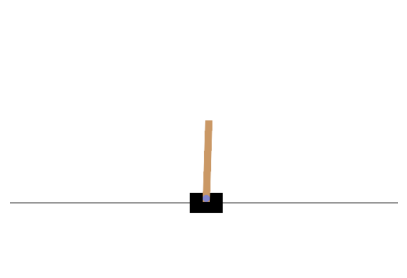

In [12]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [13]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left (0) or towards the right (1).

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [14]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

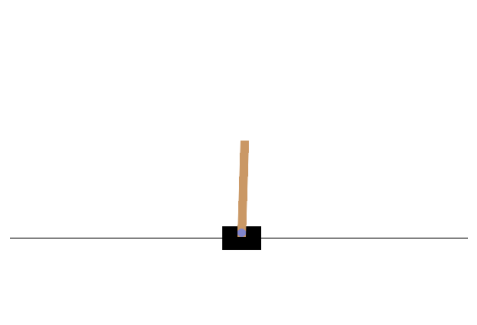

In [15]:
# extra code – displays the environment
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [16]:
reward

1.0

When the game is over, the environment returns `done=True`. In this case, it's not over yet:

In [17]:
done

False

Some environment wrappers may want to interrupt the environment early. For example, when a time limit is reached or when an object goes out of bounds. In this case, `truncated` will be set to `True`. In this case, it's not truncated yet:

In [18]:
truncated

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [19]:
info

{}

The sequence of steps between the moment the environment is reset until it is done or truncated is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True` or `truncated=True`), you should reset the environment before you continue to use it.

In [20]:
if done or truncated:
    obs, info = env.reset()

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [21]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [22]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 63 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode. You can learn more about Matplotlib animations in the [Matplotlib tutorial notebook](tools_matplotlib.ipynb#Animations).

In [23]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

In [24]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Let's write a small policy function that will use the neural net to get the probability of moving left, then let's use it to run one episode:

In [25]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

Let's see if it can learn a better policy on its own. One that does not wobble as much.

# Policy Gradients

To train this neural network we will need to define the target probabilities **y**. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions near positive rewards slightly more likely, while actions near negative rewards are made slightly less likely. First we play, then we go back and think about what we did.

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients. We will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be.

In [44]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when you cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [45]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [46]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [47]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [48]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [49]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [50]:
# extra code – let's create the neural net and reset the environment, for
#              reproducibility

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [51]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [52]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 181.2

In [53]:
# extra code – displays the animation
np.random.seed(42)
show_one_episode(pg_policy)

## Q Learning

First we are going to declare the inputs of the class
Where:

env = Cart Pole environment

alpha = step size 

gamma = discount rate

epsilon = parameter for epsilon-greedy approach

numberEpisodes = total number of simulation episodes

numberOfBins = this is a 4 dimensional list that defines the number of grid points 

lowerBounds = lower bounds (limits) for discretization, list with 4 entries:

lower bounds on cart position, cart velocity, pole angle, and pole angular velocity

 upperBounds = upper bounds (limits) for discretization, list with 4 entries:
 upper bounds on cart position, cart velocity, pole angle, and pole angular velocity

In [26]:
import numpy as np

class Q_Learning:
    
    def __init__(self,env,alpha,gamma,epsilon,numberEpisodes,numberOfBins,lowerBounds,upperBounds):
        import numpy as np
        
        self.env=env
        self.alpha=alpha
        self.gamma=gamma 
        self.epsilon=epsilon 
        self.actionNumber=env.action_space.n 
        self.numberEpisodes=numberEpisodes
        self.numberOfBins=numberOfBins
        self.lowerBounds=lowerBounds
        self.upperBounds=upperBounds
        
        # this list stores sum of rewards in every learning episode
        self.sumRewardsEpisode=[]
        
        # this matrix is the action value function matrix 
        self.Qmatrix=np.random.uniform(low=0, high=1, size=(numberOfBins[0],numberOfBins[1],numberOfBins[2],numberOfBins[3],self.actionNumber))
        
  
    #Now we need to do the disccretization that will return the the index tuple that is used to index 
    #entries of the QvalueMatrix
    def returnIndexState(self,state):
        position =      state[0]
        velocity =      state[1]
        angle    =      state[2]
        angularVelocity=state[3]
        
        cartPositionBin=np.linspace(self.lowerBounds[0],self.upperBounds[0],self.numberOfBins[0])
        cartVelocityBin=np.linspace(self.lowerBounds[1],self.upperBounds[1],self.numberOfBins[1])
        poleAngleBin=np.linspace(self.lowerBounds[2],self.upperBounds[2],self.numberOfBins[2])
        poleAngleVelocityBin=np.linspace(self.lowerBounds[3],self.upperBounds[3],self.numberOfBins[3])
        
        indexPosition=np.maximum(np.digitize(state[0],cartPositionBin)-1,0)
        indexVelocity=np.maximum(np.digitize(state[1],cartVelocityBin)-1,0)
        indexAngle=np.maximum(np.digitize(state[2],poleAngleBin)-1,0)
        indexAngularVelocity=np.maximum(np.digitize(state[3],poleAngleVelocityBin)-1,0)
        
        return tuple([indexPosition,indexVelocity,indexAngle,indexAngularVelocity])   
    
    
    
    
    #Then we have the selectAction function that basicaly selects an action on the basis of the current state
    def selectAction(self,state,index):
        
        # first 500 episodes we select completely random actions to have enough exploration
        if index<500:
            return np.random.choice(self.actionNumber)   
            
        # Returns a random real number in the half-open interval [0.0, 1.0)
        # this number is used for the epsilon greedy approach
        randomNumber=np.random.random()
        
        # after 7000 episodes, we slowly start to decrease the epsilon parameter
        if index>7000:
            self.epsilon=0.999*self.epsilon
        
        # if this condition is satisfied, we are exploring, that is, we select random actions
        if randomNumber < self.epsilon:
            # returns a random action selected from: 0,1,...,actionNumber-1
            return np.random.choice(self.actionNumber)            
        
        # otherwise, we are selecting greedy actions
        else:
            # we return the index where Qmatrix[state,:] has the max value
            # that is, since the index denotes an action, we select greedy actions
            return np.random.choice(np.where(self.Qmatrix[self.returnIndexState(state)]==np.max(self.Qmatrix[self.returnIndexState(state)]))[0])
    
    
    #Then is the simulateEpisodes function
    def simulateEpisodes(self):
        import numpy as np
        # here we loop through the episodes
        for indexEpisode in range(self.numberEpisodes):
            
            # list that stores rewards per episode - this is necessary for keeping track of convergence 
            rewardsEpisode=[]
            
            # reset the environment at the beginning of every episode
            (stateS,_)=self.env.reset()
            stateS=list(stateS)
          
            print("Simulating episode {}".format(indexEpisode))
            
            
            # here we step from one state to another
            # this will loop until a terminal state is reached
            terminalState=False
            while not terminalState:
                # return a discretized index of the state
                
                stateSIndex=self.returnIndexState(stateS)
                
                # select an action on the basis of the current state, denoted by stateS
                actionA = self.selectAction(stateS,indexEpisode)
                
                
                # here we step and return the state, reward, and boolean denoting if the state is a terminal state
                # prime means that it is the next state
                (stateSprime, reward, terminalState,_,_) = self.env.step(actionA)          
                
                rewardsEpisode.append(reward)
                
                stateSprime=list(stateSprime)
                
                stateSprimeIndex=self.returnIndexState(stateSprime)
                
                # return the max value, we do not need actionAprime...
                QmaxPrime=np.max(self.Qmatrix[stateSprimeIndex])                                               
                                             
                if not terminalState:
                    # stateS+(actionA,) - we use this notation to append the tuples
                    # for example, for stateS=(0,0,0,1) and actionA=(1,0)
                    # we have stateS+(actionA,)=(0,0,0,1,0)
                    error=reward+self.gamma*QmaxPrime-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                else:
                    # in the terminal state, we have Qmatrix[stateSprime,actionAprime]=0 
                    error=reward-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                
                # set the current state to the next state                    
                stateS=stateSprime
        
            print("Sum of rewards {}".format(np.sum(rewardsEpisode)))        
            self.sumRewardsEpisode.append(np.sum(rewardsEpisode))
    
    
    #Finally the simulateLearnedStrategy simulate the final learned optimal policy
    def simulateLearnedStrategy(self):
        import gymnasium as gym 
        import time
        env1=gym.make('CartPole-v1',render_mode='human')
        (currentState,_)=env1.reset()
        env1.render()
        timeSteps=1000
        # obtained rewards at every time step
        obtainedRewards=[]
        
        for timeIndex in range(timeSteps):
            print(timeIndex)
            # select greedy actions
            actionInStateS=np.random.choice(np.where(self.Qmatrix[self.returnIndexState(currentState)]==np.max(self.Qmatrix[self.returnIndexState(currentState)]))[0])
            currentState, reward, terminated, truncated, info =env1.step(actionInStateS)
            obtainedRewards.append(reward)   
            time.sleep(0.05)
            if (terminated):
                time.sleep(1)
                break
        return obtainedRewards,env1

After finishing implementing the class, we will call it with the attributes that we want

Simulating episode 0
Sum of rewards 19.0
Simulating episode 1
Sum of rewards 52.0
Simulating episode 2
Sum of rewards 18.0
Simulating episode 3
Sum of rewards 26.0
Simulating episode 4
Sum of rewards 54.0
Simulating episode 5
Sum of rewards 38.0
Simulating episode 6
Sum of rewards 17.0
Simulating episode 7
Sum of rewards 15.0
Simulating episode 8
Sum of rewards 12.0
Simulating episode 9
Sum of rewards 18.0
Simulating episode 10
Sum of rewards 21.0
Simulating episode 11
Sum of rewards 21.0
Simulating episode 12
Sum of rewards 19.0
Simulating episode 13
Sum of rewards 17.0
Simulating episode 14
Sum of rewards 33.0
Simulating episode 15
Sum of rewards 12.0
Simulating episode 16
Sum of rewards 18.0
Simulating episode 17
Sum of rewards 12.0
Simulating episode 18
Sum of rewards 16.0
Simulating episode 19
Sum of rewards 15.0
Simulating episode 20
Sum of rewards 20.0
Simulating episode 21
Sum of rewards 21.0
Simulating episode 22
Sum of rewards 14.0
Simulating episode 23
Sum of rewards 18.0
Si

Simulating episode 449
Sum of rewards 11.0
Simulating episode 450
Sum of rewards 13.0
Simulating episode 451
Sum of rewards 22.0
Simulating episode 452
Sum of rewards 22.0
Simulating episode 453
Sum of rewards 14.0
Simulating episode 454
Sum of rewards 16.0
Simulating episode 455
Sum of rewards 18.0
Simulating episode 456
Sum of rewards 14.0
Simulating episode 457
Sum of rewards 29.0
Simulating episode 458
Sum of rewards 11.0
Simulating episode 459
Sum of rewards 16.0
Simulating episode 460
Sum of rewards 18.0
Simulating episode 461
Sum of rewards 11.0
Simulating episode 462
Sum of rewards 35.0
Simulating episode 463
Sum of rewards 10.0
Simulating episode 464
Sum of rewards 13.0
Simulating episode 465
Sum of rewards 19.0
Simulating episode 466
Sum of rewards 10.0
Simulating episode 467
Sum of rewards 12.0
Simulating episode 468
Sum of rewards 17.0
Simulating episode 469
Sum of rewards 18.0
Simulating episode 470
Sum of rewards 47.0
Simulating episode 471
Sum of rewards 19.0
Simulating 

Sum of rewards 87.0
Simulating episode 669
Sum of rewards 72.0
Simulating episode 670
Sum of rewards 86.0
Simulating episode 671
Sum of rewards 60.0
Simulating episode 672
Sum of rewards 95.0
Simulating episode 673
Sum of rewards 138.0
Simulating episode 674
Sum of rewards 76.0
Simulating episode 675
Sum of rewards 70.0
Simulating episode 676
Sum of rewards 137.0
Simulating episode 677
Sum of rewards 63.0
Simulating episode 678
Sum of rewards 181.0
Simulating episode 679
Sum of rewards 38.0
Simulating episode 680
Sum of rewards 41.0
Simulating episode 681
Sum of rewards 72.0
Simulating episode 682
Sum of rewards 52.0
Simulating episode 683
Sum of rewards 188.0
Simulating episode 684
Sum of rewards 80.0
Simulating episode 685
Sum of rewards 88.0
Simulating episode 686
Sum of rewards 87.0
Simulating episode 687
Sum of rewards 177.0
Simulating episode 688
Sum of rewards 136.0
Simulating episode 689
Sum of rewards 73.0
Simulating episode 690
Sum of rewards 171.0
Simulating episode 691
Sum 

Simulating episode 887
Sum of rewards 135.0
Simulating episode 888
Sum of rewards 103.0
Simulating episode 889
Sum of rewards 116.0
Simulating episode 890
Sum of rewards 51.0
Simulating episode 891
Sum of rewards 56.0
Simulating episode 892
Sum of rewards 96.0
Simulating episode 893
Sum of rewards 83.0
Simulating episode 894
Sum of rewards 197.0
Simulating episode 895
Sum of rewards 84.0
Simulating episode 896
Sum of rewards 99.0
Simulating episode 897
Sum of rewards 135.0
Simulating episode 898
Sum of rewards 91.0
Simulating episode 899
Sum of rewards 61.0
Simulating episode 900
Sum of rewards 81.0
Simulating episode 901
Sum of rewards 106.0
Simulating episode 902
Sum of rewards 114.0
Simulating episode 903
Sum of rewards 46.0
Simulating episode 904
Sum of rewards 97.0
Simulating episode 905
Sum of rewards 91.0
Simulating episode 906
Sum of rewards 105.0
Simulating episode 907
Sum of rewards 177.0
Simulating episode 908
Sum of rewards 72.0
Simulating episode 909
Sum of rewards 124.0
S

Simulating episode 1095
Sum of rewards 132.0
Simulating episode 1096
Sum of rewards 122.0
Simulating episode 1097
Sum of rewards 67.0
Simulating episode 1098
Sum of rewards 164.0
Simulating episode 1099
Sum of rewards 115.0
Simulating episode 1100
Sum of rewards 101.0
Simulating episode 1101
Sum of rewards 158.0
Simulating episode 1102
Sum of rewards 66.0
Simulating episode 1103
Sum of rewards 30.0
Simulating episode 1104
Sum of rewards 56.0
Simulating episode 1105
Sum of rewards 174.0
Simulating episode 1106
Sum of rewards 70.0
Simulating episode 1107
Sum of rewards 134.0
Simulating episode 1108
Sum of rewards 117.0
Simulating episode 1109
Sum of rewards 81.0
Simulating episode 1110
Sum of rewards 79.0
Simulating episode 1111
Sum of rewards 55.0
Simulating episode 1112
Sum of rewards 72.0
Simulating episode 1113
Sum of rewards 94.0
Simulating episode 1114
Sum of rewards 105.0
Simulating episode 1115
Sum of rewards 142.0
Simulating episode 1116
Sum of rewards 67.0
Simulating episode 11

Simulating episode 1301
Sum of rewards 97.0
Simulating episode 1302
Sum of rewards 93.0
Simulating episode 1303
Sum of rewards 81.0
Simulating episode 1304
Sum of rewards 35.0
Simulating episode 1305
Sum of rewards 48.0
Simulating episode 1306
Sum of rewards 128.0
Simulating episode 1307
Sum of rewards 72.0
Simulating episode 1308
Sum of rewards 96.0
Simulating episode 1309
Sum of rewards 71.0
Simulating episode 1310
Sum of rewards 111.0
Simulating episode 1311
Sum of rewards 135.0
Simulating episode 1312
Sum of rewards 83.0
Simulating episode 1313
Sum of rewards 86.0
Simulating episode 1314
Sum of rewards 151.0
Simulating episode 1315
Sum of rewards 99.0
Simulating episode 1316
Sum of rewards 81.0
Simulating episode 1317
Sum of rewards 89.0
Simulating episode 1318
Sum of rewards 129.0
Simulating episode 1319
Sum of rewards 39.0
Simulating episode 1320
Sum of rewards 80.0
Simulating episode 1321
Sum of rewards 96.0
Simulating episode 1322
Sum of rewards 159.0
Simulating episode 1323
Su

Simulating episode 1506
Sum of rewards 139.0
Simulating episode 1507
Sum of rewards 49.0
Simulating episode 1508
Sum of rewards 55.0
Simulating episode 1509
Sum of rewards 156.0
Simulating episode 1510
Sum of rewards 149.0
Simulating episode 1511
Sum of rewards 191.0
Simulating episode 1512
Sum of rewards 144.0
Simulating episode 1513
Sum of rewards 172.0
Simulating episode 1514
Sum of rewards 49.0
Simulating episode 1515
Sum of rewards 158.0
Simulating episode 1516
Sum of rewards 78.0
Simulating episode 1517
Sum of rewards 63.0
Simulating episode 1518
Sum of rewards 48.0
Simulating episode 1519
Sum of rewards 207.0
Simulating episode 1520
Sum of rewards 88.0
Simulating episode 1521
Sum of rewards 184.0
Simulating episode 1522
Sum of rewards 106.0
Simulating episode 1523
Sum of rewards 89.0
Simulating episode 1524
Sum of rewards 64.0
Simulating episode 1525
Sum of rewards 87.0
Simulating episode 1526
Sum of rewards 102.0
Simulating episode 1527
Sum of rewards 64.0
Simulating episode 15

Simulating episode 1691
Sum of rewards 120.0
Simulating episode 1692
Sum of rewards 174.0
Simulating episode 1693
Sum of rewards 153.0
Simulating episode 1694
Sum of rewards 391.0
Simulating episode 1695
Sum of rewards 99.0
Simulating episode 1696
Sum of rewards 97.0
Simulating episode 1697
Sum of rewards 148.0
Simulating episode 1698
Sum of rewards 196.0
Simulating episode 1699
Sum of rewards 96.0
Simulating episode 1700
Sum of rewards 201.0
Simulating episode 1701
Sum of rewards 112.0
Simulating episode 1702
Sum of rewards 129.0
Simulating episode 1703
Sum of rewards 146.0
Simulating episode 1704
Sum of rewards 171.0
Simulating episode 1705
Sum of rewards 118.0
Simulating episode 1706
Sum of rewards 295.0
Simulating episode 1707
Sum of rewards 127.0
Simulating episode 1708
Sum of rewards 121.0
Simulating episode 1709
Sum of rewards 90.0
Simulating episode 1710
Sum of rewards 110.0
Simulating episode 1711
Sum of rewards 137.0
Simulating episode 1712
Sum of rewards 166.0
Simulating epi

Sum of rewards 133.0
Simulating episode 1877
Sum of rewards 87.0
Simulating episode 1878
Sum of rewards 54.0
Simulating episode 1879
Sum of rewards 106.0
Simulating episode 1880
Sum of rewards 62.0
Simulating episode 1881
Sum of rewards 90.0
Simulating episode 1882
Sum of rewards 98.0
Simulating episode 1883
Sum of rewards 122.0
Simulating episode 1884
Sum of rewards 113.0
Simulating episode 1885
Sum of rewards 52.0
Simulating episode 1886
Sum of rewards 102.0
Simulating episode 1887
Sum of rewards 93.0
Simulating episode 1888
Sum of rewards 83.0
Simulating episode 1889
Sum of rewards 85.0
Simulating episode 1890
Sum of rewards 170.0
Simulating episode 1891
Sum of rewards 257.0
Simulating episode 1892
Sum of rewards 118.0
Simulating episode 1893
Sum of rewards 40.0
Simulating episode 1894
Sum of rewards 98.0
Simulating episode 1895
Sum of rewards 54.0
Simulating episode 1896
Sum of rewards 153.0
Simulating episode 1897
Sum of rewards 147.0
Simulating episode 1898
Sum of rewards 87.0
Si

Sum of rewards 76.0
Simulating episode 2063
Sum of rewards 98.0
Simulating episode 2064
Sum of rewards 93.0
Simulating episode 2065
Sum of rewards 86.0
Simulating episode 2066
Sum of rewards 83.0
Simulating episode 2067
Sum of rewards 14.0
Simulating episode 2068
Sum of rewards 117.0
Simulating episode 2069
Sum of rewards 58.0
Simulating episode 2070
Sum of rewards 48.0
Simulating episode 2071
Sum of rewards 84.0
Simulating episode 2072
Sum of rewards 73.0
Simulating episode 2073
Sum of rewards 47.0
Simulating episode 2074
Sum of rewards 76.0
Simulating episode 2075
Sum of rewards 107.0
Simulating episode 2076
Sum of rewards 155.0
Simulating episode 2077
Sum of rewards 74.0
Simulating episode 2078
Sum of rewards 86.0
Simulating episode 2079
Sum of rewards 86.0
Simulating episode 2080
Sum of rewards 82.0
Simulating episode 2081
Sum of rewards 97.0
Simulating episode 2082
Sum of rewards 112.0
Simulating episode 2083
Sum of rewards 85.0
Simulating episode 2084
Sum of rewards 153.0
Simulat

Sum of rewards 141.0
Simulating episode 2252
Sum of rewards 163.0
Simulating episode 2253
Sum of rewards 107.0
Simulating episode 2254
Sum of rewards 151.0
Simulating episode 2255
Sum of rewards 113.0
Simulating episode 2256
Sum of rewards 121.0
Simulating episode 2257
Sum of rewards 104.0
Simulating episode 2258
Sum of rewards 86.0
Simulating episode 2259
Sum of rewards 144.0
Simulating episode 2260
Sum of rewards 276.0
Simulating episode 2261
Sum of rewards 156.0
Simulating episode 2262
Sum of rewards 83.0
Simulating episode 2263
Sum of rewards 73.0
Simulating episode 2264
Sum of rewards 60.0
Simulating episode 2265
Sum of rewards 82.0
Simulating episode 2266
Sum of rewards 71.0
Simulating episode 2267
Sum of rewards 91.0
Simulating episode 2268
Sum of rewards 73.0
Simulating episode 2269
Sum of rewards 82.0
Simulating episode 2270
Sum of rewards 79.0
Simulating episode 2271
Sum of rewards 107.0
Simulating episode 2272
Sum of rewards 69.0
Simulating episode 2273
Sum of rewards 72.0
S

Sum of rewards 127.0
Simulating episode 2437
Sum of rewards 141.0
Simulating episode 2438
Sum of rewards 160.0
Simulating episode 2439
Sum of rewards 194.0
Simulating episode 2440
Sum of rewards 61.0
Simulating episode 2441
Sum of rewards 132.0
Simulating episode 2442
Sum of rewards 161.0
Simulating episode 2443
Sum of rewards 237.0
Simulating episode 2444
Sum of rewards 127.0
Simulating episode 2445
Sum of rewards 101.0
Simulating episode 2446
Sum of rewards 176.0
Simulating episode 2447
Sum of rewards 106.0
Simulating episode 2448
Sum of rewards 89.0
Simulating episode 2449
Sum of rewards 39.0
Simulating episode 2450
Sum of rewards 176.0
Simulating episode 2451
Sum of rewards 156.0
Simulating episode 2452
Sum of rewards 79.0
Simulating episode 2453
Sum of rewards 119.0
Simulating episode 2454
Sum of rewards 209.0
Simulating episode 2455
Sum of rewards 172.0
Simulating episode 2456
Sum of rewards 107.0
Simulating episode 2457
Sum of rewards 18.0
Simulating episode 2458
Sum of rewards 

Sum of rewards 74.0
Simulating episode 2657
Sum of rewards 118.0
Simulating episode 2658
Sum of rewards 128.0
Simulating episode 2659
Sum of rewards 75.0
Simulating episode 2660
Sum of rewards 132.0
Simulating episode 2661
Sum of rewards 68.0
Simulating episode 2662
Sum of rewards 95.0
Simulating episode 2663
Sum of rewards 72.0
Simulating episode 2664
Sum of rewards 187.0
Simulating episode 2665
Sum of rewards 66.0
Simulating episode 2666
Sum of rewards 80.0
Simulating episode 2667
Sum of rewards 82.0
Simulating episode 2668
Sum of rewards 103.0
Simulating episode 2669
Sum of rewards 32.0
Simulating episode 2670
Sum of rewards 32.0
Simulating episode 2671
Sum of rewards 132.0
Simulating episode 2672
Sum of rewards 61.0
Simulating episode 2673
Sum of rewards 22.0
Simulating episode 2674
Sum of rewards 76.0
Simulating episode 2675
Sum of rewards 59.0
Simulating episode 2676
Sum of rewards 97.0
Simulating episode 2677
Sum of rewards 61.0
Simulating episode 2678
Sum of rewards 89.0
Simula

Sum of rewards 99.0
Simulating episode 2893
Sum of rewards 57.0
Simulating episode 2894
Sum of rewards 131.0
Simulating episode 2895
Sum of rewards 188.0
Simulating episode 2896
Sum of rewards 109.0
Simulating episode 2897
Sum of rewards 104.0
Simulating episode 2898
Sum of rewards 170.0
Simulating episode 2899
Sum of rewards 141.0
Simulating episode 2900
Sum of rewards 120.0
Simulating episode 2901
Sum of rewards 137.0
Simulating episode 2902
Sum of rewards 129.0
Simulating episode 2903
Sum of rewards 95.0
Simulating episode 2904
Sum of rewards 63.0
Simulating episode 2905
Sum of rewards 236.0
Simulating episode 2906
Sum of rewards 108.0
Simulating episode 2907
Sum of rewards 88.0
Simulating episode 2908
Sum of rewards 189.0
Simulating episode 2909
Sum of rewards 70.0
Simulating episode 2910
Sum of rewards 40.0
Simulating episode 2911
Sum of rewards 140.0
Simulating episode 2912
Sum of rewards 112.0
Simulating episode 2913
Sum of rewards 87.0
Simulating episode 2914
Sum of rewards 93.

Simulating episode 3089
Sum of rewards 144.0
Simulating episode 3090
Sum of rewards 167.0
Simulating episode 3091
Sum of rewards 39.0
Simulating episode 3092
Sum of rewards 304.0
Simulating episode 3093
Sum of rewards 42.0
Simulating episode 3094
Sum of rewards 473.0
Simulating episode 3095
Sum of rewards 422.0
Simulating episode 3096
Sum of rewards 242.0
Simulating episode 3097
Sum of rewards 129.0
Simulating episode 3098
Sum of rewards 121.0
Simulating episode 3099
Sum of rewards 103.0
Simulating episode 3100
Sum of rewards 110.0
Simulating episode 3101
Sum of rewards 131.0
Simulating episode 3102
Sum of rewards 157.0
Simulating episode 3103
Sum of rewards 54.0
Simulating episode 3104
Sum of rewards 71.0
Simulating episode 3105
Sum of rewards 81.0
Simulating episode 3106
Sum of rewards 87.0
Simulating episode 3107
Sum of rewards 69.0
Simulating episode 3108
Sum of rewards 93.0
Simulating episode 3109
Sum of rewards 65.0
Simulating episode 3110
Sum of rewards 96.0
Simulating episode 3

Sum of rewards 179.0
Simulating episode 3285
Sum of rewards 109.0
Simulating episode 3286
Sum of rewards 93.0
Simulating episode 3287
Sum of rewards 140.0
Simulating episode 3288
Sum of rewards 115.0
Simulating episode 3289
Sum of rewards 190.0
Simulating episode 3290
Sum of rewards 113.0
Simulating episode 3291
Sum of rewards 69.0
Simulating episode 3292
Sum of rewards 120.0
Simulating episode 3293
Sum of rewards 41.0
Simulating episode 3294
Sum of rewards 55.0
Simulating episode 3295
Sum of rewards 48.0
Simulating episode 3296
Sum of rewards 127.0
Simulating episode 3297
Sum of rewards 189.0
Simulating episode 3298
Sum of rewards 301.0
Simulating episode 3299
Sum of rewards 53.0
Simulating episode 3300
Sum of rewards 141.0
Simulating episode 3301
Sum of rewards 119.0
Simulating episode 3302
Sum of rewards 100.0
Simulating episode 3303
Sum of rewards 107.0
Simulating episode 3304
Sum of rewards 252.0
Simulating episode 3305
Sum of rewards 147.0
Simulating episode 3306
Sum of rewards 1

Sum of rewards 101.0
Simulating episode 3484
Sum of rewards 129.0
Simulating episode 3485
Sum of rewards 121.0
Simulating episode 3486
Sum of rewards 141.0
Simulating episode 3487
Sum of rewards 140.0
Simulating episode 3488
Sum of rewards 110.0
Simulating episode 3489
Sum of rewards 106.0
Simulating episode 3490
Sum of rewards 110.0
Simulating episode 3491
Sum of rewards 62.0
Simulating episode 3492
Sum of rewards 42.0
Simulating episode 3493
Sum of rewards 132.0
Simulating episode 3494
Sum of rewards 144.0
Simulating episode 3495
Sum of rewards 107.0
Simulating episode 3496
Sum of rewards 114.0
Simulating episode 3497
Sum of rewards 107.0
Simulating episode 3498
Sum of rewards 113.0
Simulating episode 3499
Sum of rewards 114.0
Simulating episode 3500
Sum of rewards 220.0
Simulating episode 3501
Sum of rewards 143.0
Simulating episode 3502
Sum of rewards 157.0
Simulating episode 3503
Sum of rewards 225.0
Simulating episode 3504
Sum of rewards 132.0
Simulating episode 3505
Sum of rewar

Sum of rewards 148.0
Simulating episode 3700
Sum of rewards 193.0
Simulating episode 3701
Sum of rewards 139.0
Simulating episode 3702
Sum of rewards 109.0
Simulating episode 3703
Sum of rewards 63.0
Simulating episode 3704
Sum of rewards 20.0
Simulating episode 3705
Sum of rewards 178.0
Simulating episode 3706
Sum of rewards 176.0
Simulating episode 3707
Sum of rewards 375.0
Simulating episode 3708
Sum of rewards 44.0
Simulating episode 3709
Sum of rewards 78.0
Simulating episode 3710
Sum of rewards 150.0
Simulating episode 3711
Sum of rewards 118.0
Simulating episode 3712
Sum of rewards 124.0
Simulating episode 3713
Sum of rewards 79.0
Simulating episode 3714
Sum of rewards 112.0
Simulating episode 3715
Sum of rewards 94.0
Simulating episode 3716
Sum of rewards 108.0
Simulating episode 3717
Sum of rewards 200.0
Simulating episode 3718
Sum of rewards 293.0
Simulating episode 3719
Sum of rewards 175.0
Simulating episode 3720
Sum of rewards 143.0
Simulating episode 3721
Sum of rewards 1

Sum of rewards 109.0
Simulating episode 3887
Sum of rewards 415.0
Simulating episode 3888
Sum of rewards 129.0
Simulating episode 3889
Sum of rewards 139.0
Simulating episode 3890
Sum of rewards 95.0
Simulating episode 3891
Sum of rewards 104.0
Simulating episode 3892
Sum of rewards 163.0
Simulating episode 3893
Sum of rewards 188.0
Simulating episode 3894
Sum of rewards 47.0
Simulating episode 3895
Sum of rewards 77.0
Simulating episode 3896
Sum of rewards 93.0
Simulating episode 3897
Sum of rewards 120.0
Simulating episode 3898
Sum of rewards 106.0
Simulating episode 3899
Sum of rewards 119.0
Simulating episode 3900
Sum of rewards 148.0
Simulating episode 3901
Sum of rewards 136.0
Simulating episode 3902
Sum of rewards 61.0
Simulating episode 3903
Sum of rewards 57.0
Simulating episode 3904
Sum of rewards 84.0
Simulating episode 3905
Sum of rewards 70.0
Simulating episode 3906
Sum of rewards 87.0
Simulating episode 3907
Sum of rewards 112.0
Simulating episode 3908
Sum of rewards 72.0

Simulating episode 4109
Sum of rewards 72.0
Simulating episode 4110
Sum of rewards 142.0
Simulating episode 4111
Sum of rewards 115.0
Simulating episode 4112
Sum of rewards 155.0
Simulating episode 4113
Sum of rewards 190.0
Simulating episode 4114
Sum of rewards 131.0
Simulating episode 4115
Sum of rewards 168.0
Simulating episode 4116
Sum of rewards 163.0
Simulating episode 4117
Sum of rewards 96.0
Simulating episode 4118
Sum of rewards 53.0
Simulating episode 4119
Sum of rewards 152.0
Simulating episode 4120
Sum of rewards 126.0
Simulating episode 4121
Sum of rewards 130.0
Simulating episode 4122
Sum of rewards 89.0
Simulating episode 4123
Sum of rewards 124.0
Simulating episode 4124
Sum of rewards 124.0
Simulating episode 4125
Sum of rewards 157.0
Simulating episode 4126
Sum of rewards 129.0
Simulating episode 4127
Sum of rewards 255.0
Simulating episode 4128
Sum of rewards 60.0
Simulating episode 4129
Sum of rewards 65.0
Simulating episode 4130
Sum of rewards 162.0
Simulating episo

Sum of rewards 130.0
Simulating episode 4298
Sum of rewards 73.0
Simulating episode 4299
Sum of rewards 118.0
Simulating episode 4300
Sum of rewards 69.0
Simulating episode 4301
Sum of rewards 110.0
Simulating episode 4302
Sum of rewards 106.0
Simulating episode 4303
Sum of rewards 140.0
Simulating episode 4304
Sum of rewards 119.0
Simulating episode 4305
Sum of rewards 192.0
Simulating episode 4306
Sum of rewards 193.0
Simulating episode 4307
Sum of rewards 239.0
Simulating episode 4308
Sum of rewards 116.0
Simulating episode 4309
Sum of rewards 53.0
Simulating episode 4310
Sum of rewards 112.0
Simulating episode 4311
Sum of rewards 207.0
Simulating episode 4312
Sum of rewards 156.0
Simulating episode 4313
Sum of rewards 16.0
Simulating episode 4314
Sum of rewards 101.0
Simulating episode 4315
Sum of rewards 100.0
Simulating episode 4316
Sum of rewards 117.0
Simulating episode 4317
Sum of rewards 25.0
Simulating episode 4318
Sum of rewards 130.0
Simulating episode 4319
Sum of rewards 

Sum of rewards 182.0
Simulating episode 4494
Sum of rewards 110.0
Simulating episode 4495
Sum of rewards 183.0
Simulating episode 4496
Sum of rewards 119.0
Simulating episode 4497
Sum of rewards 121.0
Simulating episode 4498
Sum of rewards 104.0
Simulating episode 4499
Sum of rewards 96.0
Simulating episode 4500
Sum of rewards 138.0
Simulating episode 4501
Sum of rewards 130.0
Simulating episode 4502
Sum of rewards 105.0
Simulating episode 4503
Sum of rewards 86.0
Simulating episode 4504
Sum of rewards 102.0
Simulating episode 4505
Sum of rewards 89.0
Simulating episode 4506
Sum of rewards 136.0
Simulating episode 4507
Sum of rewards 145.0
Simulating episode 4508
Sum of rewards 109.0
Simulating episode 4509
Sum of rewards 133.0
Simulating episode 4510
Sum of rewards 98.0
Simulating episode 4511
Sum of rewards 169.0
Simulating episode 4512
Sum of rewards 41.0
Simulating episode 4513
Sum of rewards 165.0
Simulating episode 4514
Sum of rewards 114.0
Simulating episode 4515
Sum of rewards 

Sum of rewards 114.0
Simulating episode 4711
Sum of rewards 137.0
Simulating episode 4712
Sum of rewards 97.0
Simulating episode 4713
Sum of rewards 111.0
Simulating episode 4714
Sum of rewards 98.0
Simulating episode 4715
Sum of rewards 98.0
Simulating episode 4716
Sum of rewards 70.0
Simulating episode 4717
Sum of rewards 131.0
Simulating episode 4718
Sum of rewards 185.0
Simulating episode 4719
Sum of rewards 137.0
Simulating episode 4720
Sum of rewards 107.0
Simulating episode 4721
Sum of rewards 115.0
Simulating episode 4722
Sum of rewards 67.0
Simulating episode 4723
Sum of rewards 170.0
Simulating episode 4724
Sum of rewards 189.0
Simulating episode 4725
Sum of rewards 73.0
Simulating episode 4726
Sum of rewards 204.0
Simulating episode 4727
Sum of rewards 236.0
Simulating episode 4728
Sum of rewards 92.0
Simulating episode 4729
Sum of rewards 128.0
Simulating episode 4730
Sum of rewards 257.0
Simulating episode 4731
Sum of rewards 142.0
Simulating episode 4732
Sum of rewards 11

Sum of rewards 219.0
Simulating episode 4906
Sum of rewards 119.0
Simulating episode 4907
Sum of rewards 103.0
Simulating episode 4908
Sum of rewards 136.0
Simulating episode 4909
Sum of rewards 192.0
Simulating episode 4910
Sum of rewards 118.0
Simulating episode 4911
Sum of rewards 191.0
Simulating episode 4912
Sum of rewards 141.0
Simulating episode 4913
Sum of rewards 133.0
Simulating episode 4914
Sum of rewards 100.0
Simulating episode 4915
Sum of rewards 185.0
Simulating episode 4916
Sum of rewards 155.0
Simulating episode 4917
Sum of rewards 169.0
Simulating episode 4918
Sum of rewards 111.0
Simulating episode 4919
Sum of rewards 112.0
Simulating episode 4920
Sum of rewards 143.0
Simulating episode 4921
Sum of rewards 130.0
Simulating episode 4922
Sum of rewards 192.0
Simulating episode 4923
Sum of rewards 112.0
Simulating episode 4924
Sum of rewards 86.0
Simulating episode 4925
Sum of rewards 229.0
Simulating episode 4926
Sum of rewards 152.0
Simulating episode 4927
Sum of rewa

Sum of rewards 106.0
Simulating episode 5106
Sum of rewards 71.0
Simulating episode 5107
Sum of rewards 100.0
Simulating episode 5108
Sum of rewards 114.0
Simulating episode 5109
Sum of rewards 84.0
Simulating episode 5110
Sum of rewards 248.0
Simulating episode 5111
Sum of rewards 175.0
Simulating episode 5112
Sum of rewards 153.0
Simulating episode 5113
Sum of rewards 175.0
Simulating episode 5114
Sum of rewards 97.0
Simulating episode 5115
Sum of rewards 54.0
Simulating episode 5116
Sum of rewards 104.0
Simulating episode 5117
Sum of rewards 187.0
Simulating episode 5118
Sum of rewards 97.0
Simulating episode 5119
Sum of rewards 117.0
Simulating episode 5120
Sum of rewards 88.0
Simulating episode 5121
Sum of rewards 198.0
Simulating episode 5122
Sum of rewards 96.0
Simulating episode 5123
Sum of rewards 125.0
Simulating episode 5124
Sum of rewards 151.0
Simulating episode 5125
Sum of rewards 87.0
Simulating episode 5126
Sum of rewards 164.0
Simulating episode 5127
Sum of rewards 146

Simulating episode 5313
Sum of rewards 83.0
Simulating episode 5314
Sum of rewards 144.0
Simulating episode 5315
Sum of rewards 171.0
Simulating episode 5316
Sum of rewards 287.0
Simulating episode 5317
Sum of rewards 213.0
Simulating episode 5318
Sum of rewards 175.0
Simulating episode 5319
Sum of rewards 152.0
Simulating episode 5320
Sum of rewards 146.0
Simulating episode 5321
Sum of rewards 172.0
Simulating episode 5322
Sum of rewards 196.0
Simulating episode 5323
Sum of rewards 159.0
Simulating episode 5324
Sum of rewards 106.0
Simulating episode 5325
Sum of rewards 257.0
Simulating episode 5326
Sum of rewards 140.0
Simulating episode 5327
Sum of rewards 152.0
Simulating episode 5328
Sum of rewards 96.0
Simulating episode 5329
Sum of rewards 189.0
Simulating episode 5330
Sum of rewards 143.0
Simulating episode 5331
Sum of rewards 209.0
Simulating episode 5332
Sum of rewards 154.0
Simulating episode 5333
Sum of rewards 214.0
Simulating episode 5334
Sum of rewards 260.0
Simulating e

Sum of rewards 81.0
Simulating episode 5508
Sum of rewards 91.0
Simulating episode 5509
Sum of rewards 111.0
Simulating episode 5510
Sum of rewards 119.0
Simulating episode 5511
Sum of rewards 135.0
Simulating episode 5512
Sum of rewards 156.0
Simulating episode 5513
Sum of rewards 163.0
Simulating episode 5514
Sum of rewards 150.0
Simulating episode 5515
Sum of rewards 124.0
Simulating episode 5516
Sum of rewards 130.0
Simulating episode 5517
Sum of rewards 279.0
Simulating episode 5518
Sum of rewards 196.0
Simulating episode 5519
Sum of rewards 99.0
Simulating episode 5520
Sum of rewards 94.0
Simulating episode 5521
Sum of rewards 166.0
Simulating episode 5522
Sum of rewards 130.0
Simulating episode 5523
Sum of rewards 146.0
Simulating episode 5524
Sum of rewards 149.0
Simulating episode 5525
Sum of rewards 135.0
Simulating episode 5526
Sum of rewards 103.0
Simulating episode 5527
Sum of rewards 194.0
Simulating episode 5528
Sum of rewards 123.0
Simulating episode 5529
Sum of rewards

Sum of rewards 221.0
Simulating episode 5705
Sum of rewards 197.0
Simulating episode 5706
Sum of rewards 135.0
Simulating episode 5707
Sum of rewards 131.0
Simulating episode 5708
Sum of rewards 141.0
Simulating episode 5709
Sum of rewards 141.0
Simulating episode 5710
Sum of rewards 157.0
Simulating episode 5711
Sum of rewards 178.0
Simulating episode 5712
Sum of rewards 357.0
Simulating episode 5713
Sum of rewards 248.0
Simulating episode 5714
Sum of rewards 143.0
Simulating episode 5715
Sum of rewards 198.0
Simulating episode 5716
Sum of rewards 170.0
Simulating episode 5717
Sum of rewards 78.0
Simulating episode 5718
Sum of rewards 249.0
Simulating episode 5719
Sum of rewards 128.0
Simulating episode 5720
Sum of rewards 151.0
Simulating episode 5721
Sum of rewards 122.0
Simulating episode 5722
Sum of rewards 187.0
Simulating episode 5723
Sum of rewards 90.0
Simulating episode 5724
Sum of rewards 65.0
Simulating episode 5725
Sum of rewards 98.0
Simulating episode 5726
Sum of rewards

Simulating episode 5897
Sum of rewards 159.0
Simulating episode 5898
Sum of rewards 134.0
Simulating episode 5899
Sum of rewards 167.0
Simulating episode 5900
Sum of rewards 139.0
Simulating episode 5901
Sum of rewards 197.0
Simulating episode 5902
Sum of rewards 105.0
Simulating episode 5903
Sum of rewards 167.0
Simulating episode 5904
Sum of rewards 131.0
Simulating episode 5905
Sum of rewards 114.0
Simulating episode 5906
Sum of rewards 168.0
Simulating episode 5907
Sum of rewards 115.0
Simulating episode 5908
Sum of rewards 33.0
Simulating episode 5909
Sum of rewards 125.0
Simulating episode 5910
Sum of rewards 129.0
Simulating episode 5911
Sum of rewards 80.0
Simulating episode 5912
Sum of rewards 85.0
Simulating episode 5913
Sum of rewards 134.0
Simulating episode 5914
Sum of rewards 96.0
Simulating episode 5915
Sum of rewards 101.0
Simulating episode 5916
Sum of rewards 201.0
Simulating episode 5917
Sum of rewards 160.0
Simulating episode 5918
Sum of rewards 220.0
Simulating epi

Sum of rewards 148.0
Simulating episode 6084
Sum of rewards 211.0
Simulating episode 6085
Sum of rewards 240.0
Simulating episode 6086
Sum of rewards 153.0
Simulating episode 6087
Sum of rewards 363.0
Simulating episode 6088
Sum of rewards 114.0
Simulating episode 6089
Sum of rewards 163.0
Simulating episode 6090
Sum of rewards 191.0
Simulating episode 6091
Sum of rewards 143.0
Simulating episode 6092
Sum of rewards 145.0
Simulating episode 6093
Sum of rewards 135.0
Simulating episode 6094
Sum of rewards 182.0
Simulating episode 6095
Sum of rewards 102.0
Simulating episode 6096
Sum of rewards 150.0
Simulating episode 6097
Sum of rewards 204.0
Simulating episode 6098
Sum of rewards 159.0
Simulating episode 6099
Sum of rewards 187.0
Simulating episode 6100
Sum of rewards 157.0
Simulating episode 6101
Sum of rewards 221.0
Simulating episode 6102
Sum of rewards 121.0
Simulating episode 6103
Sum of rewards 114.0
Simulating episode 6104
Sum of rewards 160.0
Simulating episode 6105
Sum of rew

Sum of rewards 128.0
Simulating episode 6270
Sum of rewards 176.0
Simulating episode 6271
Sum of rewards 188.0
Simulating episode 6272
Sum of rewards 164.0
Simulating episode 6273
Sum of rewards 126.0
Simulating episode 6274
Sum of rewards 111.0
Simulating episode 6275
Sum of rewards 100.0
Simulating episode 6276
Sum of rewards 79.0
Simulating episode 6277
Sum of rewards 106.0
Simulating episode 6278
Sum of rewards 97.0
Simulating episode 6279
Sum of rewards 65.0
Simulating episode 6280
Sum of rewards 94.0
Simulating episode 6281
Sum of rewards 144.0
Simulating episode 6282
Sum of rewards 102.0
Simulating episode 6283
Sum of rewards 219.0
Simulating episode 6284
Sum of rewards 388.0
Simulating episode 6285
Sum of rewards 261.0
Simulating episode 6286
Sum of rewards 275.0
Simulating episode 6287
Sum of rewards 180.0
Simulating episode 6288
Sum of rewards 90.0
Simulating episode 6289
Sum of rewards 210.0
Simulating episode 6290
Sum of rewards 84.0
Simulating episode 6291
Sum of rewards 1

Sum of rewards 177.0
Simulating episode 6458
Sum of rewards 88.0
Simulating episode 6459
Sum of rewards 196.0
Simulating episode 6460
Sum of rewards 112.0
Simulating episode 6461
Sum of rewards 134.0
Simulating episode 6462
Sum of rewards 162.0
Simulating episode 6463
Sum of rewards 133.0
Simulating episode 6464
Sum of rewards 112.0
Simulating episode 6465
Sum of rewards 25.0
Simulating episode 6466
Sum of rewards 176.0
Simulating episode 6467
Sum of rewards 107.0
Simulating episode 6468
Sum of rewards 142.0
Simulating episode 6469
Sum of rewards 199.0
Simulating episode 6470
Sum of rewards 195.0
Simulating episode 6471
Sum of rewards 99.0
Simulating episode 6472
Sum of rewards 143.0
Simulating episode 6473
Sum of rewards 170.0
Simulating episode 6474
Sum of rewards 301.0
Simulating episode 6475
Sum of rewards 107.0
Simulating episode 6476
Sum of rewards 121.0
Simulating episode 6477
Sum of rewards 117.0
Simulating episode 6478
Sum of rewards 85.0
Simulating episode 6479
Sum of rewards

Sum of rewards 164.0
Simulating episode 6661
Sum of rewards 123.0
Simulating episode 6662
Sum of rewards 166.0
Simulating episode 6663
Sum of rewards 177.0
Simulating episode 6664
Sum of rewards 124.0
Simulating episode 6665
Sum of rewards 157.0
Simulating episode 6666
Sum of rewards 113.0
Simulating episode 6667
Sum of rewards 136.0
Simulating episode 6668
Sum of rewards 97.0
Simulating episode 6669
Sum of rewards 148.0
Simulating episode 6670
Sum of rewards 167.0
Simulating episode 6671
Sum of rewards 146.0
Simulating episode 6672
Sum of rewards 139.0
Simulating episode 6673
Sum of rewards 111.0
Simulating episode 6674
Sum of rewards 193.0
Simulating episode 6675
Sum of rewards 169.0
Simulating episode 6676
Sum of rewards 82.0
Simulating episode 6677
Sum of rewards 130.0
Simulating episode 6678
Sum of rewards 130.0
Simulating episode 6679
Sum of rewards 120.0
Simulating episode 6680
Sum of rewards 159.0
Simulating episode 6681
Sum of rewards 87.0
Simulating episode 6682
Sum of reward

Sum of rewards 164.0
Simulating episode 6873
Sum of rewards 119.0
Simulating episode 6874
Sum of rewards 88.0
Simulating episode 6875
Sum of rewards 225.0
Simulating episode 6876
Sum of rewards 176.0
Simulating episode 6877
Sum of rewards 142.0
Simulating episode 6878
Sum of rewards 163.0
Simulating episode 6879
Sum of rewards 185.0
Simulating episode 6880
Sum of rewards 168.0
Simulating episode 6881
Sum of rewards 202.0
Simulating episode 6882
Sum of rewards 322.0
Simulating episode 6883
Sum of rewards 168.0
Simulating episode 6884
Sum of rewards 99.0
Simulating episode 6885
Sum of rewards 117.0
Simulating episode 6886
Sum of rewards 160.0
Simulating episode 6887
Sum of rewards 156.0
Simulating episode 6888
Sum of rewards 221.0
Simulating episode 6889
Sum of rewards 183.0
Simulating episode 6890
Sum of rewards 149.0
Simulating episode 6891
Sum of rewards 202.0
Simulating episode 6892
Sum of rewards 87.0
Simulating episode 6893
Sum of rewards 127.0
Simulating episode 6894
Sum of reward

Sum of rewards 118.0
Simulating episode 7059
Sum of rewards 148.0
Simulating episode 7060
Sum of rewards 163.0
Simulating episode 7061
Sum of rewards 131.0
Simulating episode 7062
Sum of rewards 163.0
Simulating episode 7063
Sum of rewards 124.0
Simulating episode 7064
Sum of rewards 125.0
Simulating episode 7065
Sum of rewards 107.0
Simulating episode 7066
Sum of rewards 136.0
Simulating episode 7067
Sum of rewards 128.0
Simulating episode 7068
Sum of rewards 134.0
Simulating episode 7069
Sum of rewards 128.0
Simulating episode 7070
Sum of rewards 146.0
Simulating episode 7071
Sum of rewards 151.0
Simulating episode 7072
Sum of rewards 147.0
Simulating episode 7073
Sum of rewards 145.0
Simulating episode 7074
Sum of rewards 139.0
Simulating episode 7075
Sum of rewards 126.0
Simulating episode 7076
Sum of rewards 159.0
Simulating episode 7077
Sum of rewards 191.0
Simulating episode 7078
Sum of rewards 193.0
Simulating episode 7079
Sum of rewards 210.0
Simulating episode 7080
Sum of rew

Simulating episode 7288
Sum of rewards 142.0
Simulating episode 7289
Sum of rewards 156.0
Simulating episode 7290
Sum of rewards 116.0
Simulating episode 7291
Sum of rewards 110.0
Simulating episode 7292
Sum of rewards 228.0
Simulating episode 7293
Sum of rewards 133.0
Simulating episode 7294
Sum of rewards 157.0
Simulating episode 7295
Sum of rewards 133.0
Simulating episode 7296
Sum of rewards 130.0
Simulating episode 7297
Sum of rewards 147.0
Simulating episode 7298
Sum of rewards 164.0
Simulating episode 7299
Sum of rewards 134.0
Simulating episode 7300
Sum of rewards 123.0
Simulating episode 7301
Sum of rewards 147.0
Simulating episode 7302
Sum of rewards 132.0
Simulating episode 7303
Sum of rewards 170.0
Simulating episode 7304
Sum of rewards 168.0
Simulating episode 7305
Sum of rewards 204.0
Simulating episode 7306
Sum of rewards 162.0
Simulating episode 7307
Sum of rewards 127.0
Simulating episode 7308
Sum of rewards 130.0
Simulating episode 7309
Sum of rewards 155.0
Simulating

Sum of rewards 170.0
Simulating episode 7485
Sum of rewards 116.0
Simulating episode 7486
Sum of rewards 149.0
Simulating episode 7487
Sum of rewards 161.0
Simulating episode 7488
Sum of rewards 144.0
Simulating episode 7489
Sum of rewards 226.0
Simulating episode 7490
Sum of rewards 187.0
Simulating episode 7491
Sum of rewards 176.0
Simulating episode 7492
Sum of rewards 205.0
Simulating episode 7493
Sum of rewards 169.0
Simulating episode 7494
Sum of rewards 220.0
Simulating episode 7495
Sum of rewards 172.0
Simulating episode 7496
Sum of rewards 211.0
Simulating episode 7497
Sum of rewards 182.0
Simulating episode 7498
Sum of rewards 161.0
Simulating episode 7499
Sum of rewards 224.0
Simulating episode 7500
Sum of rewards 174.0
Simulating episode 7501
Sum of rewards 144.0
Simulating episode 7502
Sum of rewards 197.0
Simulating episode 7503
Sum of rewards 179.0
Simulating episode 7504
Sum of rewards 169.0
Simulating episode 7505
Sum of rewards 154.0
Simulating episode 7506
Sum of rew

Sum of rewards 171.0
Simulating episode 7712
Sum of rewards 128.0
Simulating episode 7713
Sum of rewards 140.0
Simulating episode 7714
Sum of rewards 125.0
Simulating episode 7715
Sum of rewards 215.0
Simulating episode 7716
Sum of rewards 123.0
Simulating episode 7717
Sum of rewards 122.0
Simulating episode 7718
Sum of rewards 94.0
Simulating episode 7719
Sum of rewards 118.0
Simulating episode 7720
Sum of rewards 128.0
Simulating episode 7721
Sum of rewards 112.0
Simulating episode 7722
Sum of rewards 124.0
Simulating episode 7723
Sum of rewards 135.0
Simulating episode 7724
Sum of rewards 161.0
Simulating episode 7725
Sum of rewards 206.0
Simulating episode 7726
Sum of rewards 269.0
Simulating episode 7727
Sum of rewards 191.0
Simulating episode 7728
Sum of rewards 225.0
Simulating episode 7729
Sum of rewards 151.0
Simulating episode 7730
Sum of rewards 241.0
Simulating episode 7731
Sum of rewards 294.0
Simulating episode 7732
Sum of rewards 305.0
Simulating episode 7733
Sum of rewa

Sum of rewards 196.0
Simulating episode 7914
Sum of rewards 153.0
Simulating episode 7915
Sum of rewards 154.0
Simulating episode 7916
Sum of rewards 157.0
Simulating episode 7917
Sum of rewards 186.0
Simulating episode 7918
Sum of rewards 172.0
Simulating episode 7919
Sum of rewards 145.0
Simulating episode 7920
Sum of rewards 228.0
Simulating episode 7921
Sum of rewards 167.0
Simulating episode 7922
Sum of rewards 252.0
Simulating episode 7923
Sum of rewards 166.0
Simulating episode 7924
Sum of rewards 288.0
Simulating episode 7925
Sum of rewards 168.0
Simulating episode 7926
Sum of rewards 195.0
Simulating episode 7927
Sum of rewards 164.0
Simulating episode 7928
Sum of rewards 141.0
Simulating episode 7929
Sum of rewards 155.0
Simulating episode 7930
Sum of rewards 201.0
Simulating episode 7931
Sum of rewards 122.0
Simulating episode 7932
Sum of rewards 170.0
Simulating episode 7933
Sum of rewards 159.0
Simulating episode 7934
Sum of rewards 199.0
Simulating episode 7935
Sum of rew

Sum of rewards 139.0
Simulating episode 8120
Sum of rewards 133.0
Simulating episode 8121
Sum of rewards 114.0
Simulating episode 8122
Sum of rewards 135.0
Simulating episode 8123
Sum of rewards 127.0
Simulating episode 8124
Sum of rewards 109.0
Simulating episode 8125
Sum of rewards 130.0
Simulating episode 8126
Sum of rewards 103.0
Simulating episode 8127
Sum of rewards 140.0
Simulating episode 8128
Sum of rewards 109.0
Simulating episode 8129
Sum of rewards 115.0
Simulating episode 8130
Sum of rewards 121.0
Simulating episode 8131
Sum of rewards 99.0
Simulating episode 8132
Sum of rewards 134.0
Simulating episode 8133
Sum of rewards 108.0
Simulating episode 8134
Sum of rewards 116.0
Simulating episode 8135
Sum of rewards 135.0
Simulating episode 8136
Sum of rewards 130.0
Simulating episode 8137
Sum of rewards 133.0
Simulating episode 8138
Sum of rewards 111.0
Simulating episode 8139
Sum of rewards 104.0
Simulating episode 8140
Sum of rewards 173.0
Simulating episode 8141
Sum of rewa

Simulating episode 8321
Sum of rewards 151.0
Simulating episode 8322
Sum of rewards 137.0
Simulating episode 8323
Sum of rewards 145.0
Simulating episode 8324
Sum of rewards 122.0
Simulating episode 8325
Sum of rewards 112.0
Simulating episode 8326
Sum of rewards 113.0
Simulating episode 8327
Sum of rewards 197.0
Simulating episode 8328
Sum of rewards 163.0
Simulating episode 8329
Sum of rewards 139.0
Simulating episode 8330
Sum of rewards 88.0
Simulating episode 8331
Sum of rewards 139.0
Simulating episode 8332
Sum of rewards 101.0
Simulating episode 8333
Sum of rewards 145.0
Simulating episode 8334
Sum of rewards 109.0
Simulating episode 8335
Sum of rewards 93.0
Simulating episode 8336
Sum of rewards 123.0
Simulating episode 8337
Sum of rewards 122.0
Simulating episode 8338
Sum of rewards 145.0
Simulating episode 8339
Sum of rewards 145.0
Simulating episode 8340
Sum of rewards 154.0
Simulating episode 8341
Sum of rewards 123.0
Simulating episode 8342
Sum of rewards 147.0
Simulating e

Simulating episode 8511
Sum of rewards 197.0
Simulating episode 8512
Sum of rewards 185.0
Simulating episode 8513
Sum of rewards 187.0
Simulating episode 8514
Sum of rewards 204.0
Simulating episode 8515
Sum of rewards 145.0
Simulating episode 8516
Sum of rewards 152.0
Simulating episode 8517
Sum of rewards 161.0
Simulating episode 8518
Sum of rewards 186.0
Simulating episode 8519
Sum of rewards 198.0
Simulating episode 8520
Sum of rewards 131.0
Simulating episode 8521
Sum of rewards 159.0
Simulating episode 8522
Sum of rewards 140.0
Simulating episode 8523
Sum of rewards 126.0
Simulating episode 8524
Sum of rewards 133.0
Simulating episode 8525
Sum of rewards 188.0
Simulating episode 8526
Sum of rewards 158.0
Simulating episode 8527
Sum of rewards 132.0
Simulating episode 8528
Sum of rewards 134.0
Simulating episode 8529
Sum of rewards 129.0
Simulating episode 8530
Sum of rewards 213.0
Simulating episode 8531
Sum of rewards 148.0
Simulating episode 8532
Sum of rewards 132.0
Simulating

Simulating episode 8703
Sum of rewards 184.0
Simulating episode 8704
Sum of rewards 138.0
Simulating episode 8705
Sum of rewards 172.0
Simulating episode 8706
Sum of rewards 170.0
Simulating episode 8707
Sum of rewards 164.0
Simulating episode 8708
Sum of rewards 140.0
Simulating episode 8709
Sum of rewards 117.0
Simulating episode 8710
Sum of rewards 174.0
Simulating episode 8711
Sum of rewards 140.0
Simulating episode 8712
Sum of rewards 160.0
Simulating episode 8713
Sum of rewards 165.0
Simulating episode 8714
Sum of rewards 134.0
Simulating episode 8715
Sum of rewards 154.0
Simulating episode 8716
Sum of rewards 168.0
Simulating episode 8717
Sum of rewards 167.0
Simulating episode 8718
Sum of rewards 120.0
Simulating episode 8719
Sum of rewards 130.0
Simulating episode 8720
Sum of rewards 104.0
Simulating episode 8721
Sum of rewards 145.0
Simulating episode 8722
Sum of rewards 126.0
Simulating episode 8723
Sum of rewards 185.0
Simulating episode 8724
Sum of rewards 158.0
Simulating

Sum of rewards 208.0
Simulating episode 8916
Sum of rewards 186.0
Simulating episode 8917
Sum of rewards 150.0
Simulating episode 8918
Sum of rewards 155.0
Simulating episode 8919
Sum of rewards 150.0
Simulating episode 8920
Sum of rewards 136.0
Simulating episode 8921
Sum of rewards 186.0
Simulating episode 8922
Sum of rewards 142.0
Simulating episode 8923
Sum of rewards 202.0
Simulating episode 8924
Sum of rewards 256.0
Simulating episode 8925
Sum of rewards 186.0
Simulating episode 8926
Sum of rewards 147.0
Simulating episode 8927
Sum of rewards 270.0
Simulating episode 8928
Sum of rewards 198.0
Simulating episode 8929
Sum of rewards 346.0
Simulating episode 8930
Sum of rewards 173.0
Simulating episode 8931
Sum of rewards 180.0
Simulating episode 8932
Sum of rewards 181.0
Simulating episode 8933
Sum of rewards 177.0
Simulating episode 8934
Sum of rewards 207.0
Simulating episode 8935
Sum of rewards 118.0
Simulating episode 8936
Sum of rewards 179.0
Simulating episode 8937
Sum of rew

Sum of rewards 143.0
Simulating episode 9108
Sum of rewards 166.0
Simulating episode 9109
Sum of rewards 127.0
Simulating episode 9110
Sum of rewards 145.0
Simulating episode 9111
Sum of rewards 158.0
Simulating episode 9112
Sum of rewards 137.0
Simulating episode 9113
Sum of rewards 183.0
Simulating episode 9114
Sum of rewards 110.0
Simulating episode 9115
Sum of rewards 195.0
Simulating episode 9116
Sum of rewards 237.0
Simulating episode 9117
Sum of rewards 142.0
Simulating episode 9118
Sum of rewards 137.0
Simulating episode 9119
Sum of rewards 179.0
Simulating episode 9120
Sum of rewards 136.0
Simulating episode 9121
Sum of rewards 171.0
Simulating episode 9122
Sum of rewards 135.0
Simulating episode 9123
Sum of rewards 107.0
Simulating episode 9124
Sum of rewards 183.0
Simulating episode 9125
Sum of rewards 209.0
Simulating episode 9126
Sum of rewards 201.0
Simulating episode 9127
Sum of rewards 184.0
Simulating episode 9128
Sum of rewards 111.0
Simulating episode 9129
Sum of rew

Sum of rewards 184.0
Simulating episode 9325
Sum of rewards 133.0
Simulating episode 9326
Sum of rewards 172.0
Simulating episode 9327
Sum of rewards 198.0
Simulating episode 9328
Sum of rewards 226.0
Simulating episode 9329
Sum of rewards 127.0
Simulating episode 9330
Sum of rewards 150.0
Simulating episode 9331
Sum of rewards 141.0
Simulating episode 9332
Sum of rewards 133.0
Simulating episode 9333
Sum of rewards 144.0
Simulating episode 9334
Sum of rewards 163.0
Simulating episode 9335
Sum of rewards 133.0
Simulating episode 9336
Sum of rewards 162.0
Simulating episode 9337
Sum of rewards 141.0
Simulating episode 9338
Sum of rewards 146.0
Simulating episode 9339
Sum of rewards 142.0
Simulating episode 9340
Sum of rewards 135.0
Simulating episode 9341
Sum of rewards 133.0
Simulating episode 9342
Sum of rewards 128.0
Simulating episode 9343
Sum of rewards 150.0
Simulating episode 9344
Sum of rewards 141.0
Simulating episode 9345
Sum of rewards 142.0
Simulating episode 9346
Sum of rew

Sum of rewards 132.0
Simulating episode 9509
Sum of rewards 171.0
Simulating episode 9510
Sum of rewards 145.0
Simulating episode 9511
Sum of rewards 130.0
Simulating episode 9512
Sum of rewards 130.0
Simulating episode 9513
Sum of rewards 120.0
Simulating episode 9514
Sum of rewards 147.0
Simulating episode 9515
Sum of rewards 157.0
Simulating episode 9516
Sum of rewards 127.0
Simulating episode 9517
Sum of rewards 133.0
Simulating episode 9518
Sum of rewards 154.0
Simulating episode 9519
Sum of rewards 137.0
Simulating episode 9520
Sum of rewards 128.0
Simulating episode 9521
Sum of rewards 144.0
Simulating episode 9522
Sum of rewards 188.0
Simulating episode 9523
Sum of rewards 166.0
Simulating episode 9524
Sum of rewards 146.0
Simulating episode 9525
Sum of rewards 125.0
Simulating episode 9526
Sum of rewards 169.0
Simulating episode 9527
Sum of rewards 130.0
Simulating episode 9528
Sum of rewards 145.0
Simulating episode 9529
Sum of rewards 156.0
Simulating episode 9530
Sum of rew

Sum of rewards 161.0
Simulating episode 9713
Sum of rewards 147.0
Simulating episode 9714
Sum of rewards 135.0
Simulating episode 9715
Sum of rewards 131.0
Simulating episode 9716
Sum of rewards 167.0
Simulating episode 9717
Sum of rewards 131.0
Simulating episode 9718
Sum of rewards 137.0
Simulating episode 9719
Sum of rewards 111.0
Simulating episode 9720
Sum of rewards 101.0
Simulating episode 9721
Sum of rewards 128.0
Simulating episode 9722
Sum of rewards 135.0
Simulating episode 9723
Sum of rewards 98.0
Simulating episode 9724
Sum of rewards 136.0
Simulating episode 9725
Sum of rewards 123.0
Simulating episode 9726
Sum of rewards 138.0
Simulating episode 9727
Sum of rewards 159.0
Simulating episode 9728
Sum of rewards 126.0
Simulating episode 9729
Sum of rewards 144.0
Simulating episode 9730
Sum of rewards 131.0
Simulating episode 9731
Sum of rewards 159.0
Simulating episode 9732
Sum of rewards 170.0
Simulating episode 9733
Sum of rewards 142.0
Simulating episode 9734
Sum of rewa

Sum of rewards 150.0
Simulating episode 9909
Sum of rewards 172.0
Simulating episode 9910
Sum of rewards 150.0
Simulating episode 9911
Sum of rewards 143.0
Simulating episode 9912
Sum of rewards 150.0
Simulating episode 9913
Sum of rewards 171.0
Simulating episode 9914
Sum of rewards 227.0
Simulating episode 9915
Sum of rewards 177.0
Simulating episode 9916
Sum of rewards 186.0
Simulating episode 9917
Sum of rewards 148.0
Simulating episode 9918
Sum of rewards 171.0
Simulating episode 9919
Sum of rewards 154.0
Simulating episode 9920
Sum of rewards 185.0
Simulating episode 9921
Sum of rewards 135.0
Simulating episode 9922
Sum of rewards 234.0
Simulating episode 9923
Sum of rewards 147.0
Simulating episode 9924
Sum of rewards 163.0
Simulating episode 9925
Sum of rewards 211.0
Simulating episode 9926
Sum of rewards 137.0
Simulating episode 9927
Sum of rewards 158.0
Simulating episode 9928
Sum of rewards 188.0
Simulating episode 9929
Sum of rewards 208.0
Simulating episode 9930
Sum of rew

Sum of rewards 138.0
Simulating episode 10096
Sum of rewards 143.0
Simulating episode 10097
Sum of rewards 142.0
Simulating episode 10098
Sum of rewards 137.0
Simulating episode 10099
Sum of rewards 217.0
Simulating episode 10100
Sum of rewards 183.0
Simulating episode 10101
Sum of rewards 169.0
Simulating episode 10102
Sum of rewards 167.0
Simulating episode 10103
Sum of rewards 177.0
Simulating episode 10104
Sum of rewards 133.0
Simulating episode 10105
Sum of rewards 180.0
Simulating episode 10106
Sum of rewards 212.0
Simulating episode 10107
Sum of rewards 135.0
Simulating episode 10108
Sum of rewards 166.0
Simulating episode 10109
Sum of rewards 222.0
Simulating episode 10110
Sum of rewards 162.0
Simulating episode 10111
Sum of rewards 139.0
Simulating episode 10112
Sum of rewards 144.0
Simulating episode 10113
Sum of rewards 158.0
Simulating episode 10114
Sum of rewards 178.0
Simulating episode 10115
Sum of rewards 144.0
Simulating episode 10116
Sum of rewards 155.0
Simulating ep

Simulating episode 10287
Sum of rewards 138.0
Simulating episode 10288
Sum of rewards 189.0
Simulating episode 10289
Sum of rewards 149.0
Simulating episode 10290
Sum of rewards 145.0
Simulating episode 10291
Sum of rewards 213.0
Simulating episode 10292
Sum of rewards 178.0
Simulating episode 10293
Sum of rewards 167.0
Simulating episode 10294
Sum of rewards 136.0
Simulating episode 10295
Sum of rewards 145.0
Simulating episode 10296
Sum of rewards 181.0
Simulating episode 10297
Sum of rewards 177.0
Simulating episode 10298
Sum of rewards 167.0
Simulating episode 10299
Sum of rewards 199.0
Simulating episode 10300
Sum of rewards 143.0
Simulating episode 10301
Sum of rewards 175.0
Simulating episode 10302
Sum of rewards 164.0
Simulating episode 10303
Sum of rewards 124.0
Simulating episode 10304
Sum of rewards 150.0
Simulating episode 10305
Sum of rewards 200.0
Simulating episode 10306
Sum of rewards 178.0
Simulating episode 10307
Sum of rewards 158.0
Simulating episode 10308
Sum of re

Sum of rewards 168.0
Simulating episode 10493
Sum of rewards 131.0
Simulating episode 10494
Sum of rewards 137.0
Simulating episode 10495
Sum of rewards 168.0
Simulating episode 10496
Sum of rewards 139.0
Simulating episode 10497
Sum of rewards 140.0
Simulating episode 10498
Sum of rewards 181.0
Simulating episode 10499
Sum of rewards 142.0
Simulating episode 10500
Sum of rewards 130.0
Simulating episode 10501
Sum of rewards 122.0
Simulating episode 10502
Sum of rewards 154.0
Simulating episode 10503
Sum of rewards 194.0
Simulating episode 10504
Sum of rewards 144.0
Simulating episode 10505
Sum of rewards 178.0
Simulating episode 10506
Sum of rewards 152.0
Simulating episode 10507
Sum of rewards 123.0
Simulating episode 10508
Sum of rewards 170.0
Simulating episode 10509
Sum of rewards 149.0
Simulating episode 10510
Sum of rewards 153.0
Simulating episode 10511
Sum of rewards 153.0
Simulating episode 10512
Sum of rewards 179.0
Simulating episode 10513
Sum of rewards 155.0
Simulating ep

Sum of rewards 189.0
Simulating episode 10691
Sum of rewards 159.0
Simulating episode 10692
Sum of rewards 176.0
Simulating episode 10693
Sum of rewards 90.0
Simulating episode 10694
Sum of rewards 165.0
Simulating episode 10695
Sum of rewards 144.0
Simulating episode 10696
Sum of rewards 144.0
Simulating episode 10697
Sum of rewards 175.0
Simulating episode 10698
Sum of rewards 176.0
Simulating episode 10699
Sum of rewards 176.0
Simulating episode 10700
Sum of rewards 178.0
Simulating episode 10701
Sum of rewards 167.0
Simulating episode 10702
Sum of rewards 251.0
Simulating episode 10703
Sum of rewards 223.0
Simulating episode 10704
Sum of rewards 160.0
Simulating episode 10705
Sum of rewards 135.0
Simulating episode 10706
Sum of rewards 125.0
Simulating episode 10707
Sum of rewards 122.0
Simulating episode 10708
Sum of rewards 130.0
Simulating episode 10709
Sum of rewards 163.0
Simulating episode 10710
Sum of rewards 155.0
Simulating episode 10711
Sum of rewards 158.0
Simulating epi

Simulating episode 10878
Sum of rewards 124.0
Simulating episode 10879
Sum of rewards 148.0
Simulating episode 10880
Sum of rewards 160.0
Simulating episode 10881
Sum of rewards 172.0
Simulating episode 10882
Sum of rewards 189.0
Simulating episode 10883
Sum of rewards 134.0
Simulating episode 10884
Sum of rewards 116.0
Simulating episode 10885
Sum of rewards 219.0
Simulating episode 10886
Sum of rewards 135.0
Simulating episode 10887
Sum of rewards 166.0
Simulating episode 10888
Sum of rewards 140.0
Simulating episode 10889
Sum of rewards 152.0
Simulating episode 10890
Sum of rewards 174.0
Simulating episode 10891
Sum of rewards 160.0
Simulating episode 10892
Sum of rewards 163.0
Simulating episode 10893
Sum of rewards 148.0
Simulating episode 10894
Sum of rewards 108.0
Simulating episode 10895
Sum of rewards 144.0
Simulating episode 10896
Sum of rewards 99.0
Simulating episode 10897
Sum of rewards 164.0
Simulating episode 10898
Sum of rewards 196.0
Simulating episode 10899
Sum of rew

Sum of rewards 145.0
Simulating episode 11093
Sum of rewards 178.0
Simulating episode 11094
Sum of rewards 140.0
Simulating episode 11095
Sum of rewards 135.0
Simulating episode 11096
Sum of rewards 190.0
Simulating episode 11097
Sum of rewards 153.0
Simulating episode 11098
Sum of rewards 131.0
Simulating episode 11099
Sum of rewards 236.0
Simulating episode 11100
Sum of rewards 155.0
Simulating episode 11101
Sum of rewards 134.0
Simulating episode 11102
Sum of rewards 177.0
Simulating episode 11103
Sum of rewards 157.0
Simulating episode 11104
Sum of rewards 145.0
Simulating episode 11105
Sum of rewards 139.0
Simulating episode 11106
Sum of rewards 135.0
Simulating episode 11107
Sum of rewards 149.0
Simulating episode 11108
Sum of rewards 170.0
Simulating episode 11109
Sum of rewards 153.0
Simulating episode 11110
Sum of rewards 138.0
Simulating episode 11111
Sum of rewards 161.0
Simulating episode 11112
Sum of rewards 194.0
Simulating episode 11113
Sum of rewards 158.0
Simulating ep

Sum of rewards 119.0
Simulating episode 11286
Sum of rewards 156.0
Simulating episode 11287
Sum of rewards 120.0
Simulating episode 11288
Sum of rewards 143.0
Simulating episode 11289
Sum of rewards 136.0
Simulating episode 11290
Sum of rewards 152.0
Simulating episode 11291
Sum of rewards 156.0
Simulating episode 11292
Sum of rewards 144.0
Simulating episode 11293
Sum of rewards 130.0
Simulating episode 11294
Sum of rewards 155.0
Simulating episode 11295
Sum of rewards 145.0
Simulating episode 11296
Sum of rewards 183.0
Simulating episode 11297
Sum of rewards 147.0
Simulating episode 11298
Sum of rewards 146.0
Simulating episode 11299
Sum of rewards 160.0
Simulating episode 11300
Sum of rewards 136.0
Simulating episode 11301
Sum of rewards 185.0
Simulating episode 11302
Sum of rewards 148.0
Simulating episode 11303
Sum of rewards 163.0
Simulating episode 11304
Sum of rewards 148.0
Simulating episode 11305
Sum of rewards 204.0
Simulating episode 11306
Sum of rewards 143.0
Simulating ep

Sum of rewards 200.0
Simulating episode 11490
Sum of rewards 143.0
Simulating episode 11491
Sum of rewards 147.0
Simulating episode 11492
Sum of rewards 155.0
Simulating episode 11493
Sum of rewards 184.0
Simulating episode 11494
Sum of rewards 176.0
Simulating episode 11495
Sum of rewards 187.0
Simulating episode 11496
Sum of rewards 173.0
Simulating episode 11497
Sum of rewards 163.0
Simulating episode 11498
Sum of rewards 221.0
Simulating episode 11499
Sum of rewards 186.0
Simulating episode 11500
Sum of rewards 131.0
Simulating episode 11501
Sum of rewards 135.0
Simulating episode 11502
Sum of rewards 141.0
Simulating episode 11503
Sum of rewards 138.0
Simulating episode 11504
Sum of rewards 137.0
Simulating episode 11505
Sum of rewards 170.0
Simulating episode 11506
Sum of rewards 128.0
Simulating episode 11507
Sum of rewards 170.0
Simulating episode 11508
Sum of rewards 137.0
Simulating episode 11509
Sum of rewards 150.0
Simulating episode 11510
Sum of rewards 159.0
Simulating ep

Sum of rewards 163.0
Simulating episode 11689
Sum of rewards 222.0
Simulating episode 11690
Sum of rewards 154.0
Simulating episode 11691
Sum of rewards 162.0
Simulating episode 11692
Sum of rewards 168.0
Simulating episode 11693
Sum of rewards 126.0
Simulating episode 11694
Sum of rewards 154.0
Simulating episode 11695
Sum of rewards 136.0
Simulating episode 11696
Sum of rewards 187.0
Simulating episode 11697
Sum of rewards 158.0
Simulating episode 11698
Sum of rewards 140.0
Simulating episode 11699
Sum of rewards 125.0
Simulating episode 11700
Sum of rewards 167.0
Simulating episode 11701
Sum of rewards 135.0
Simulating episode 11702
Sum of rewards 179.0
Simulating episode 11703
Sum of rewards 162.0
Simulating episode 11704
Sum of rewards 134.0
Simulating episode 11705
Sum of rewards 118.0
Simulating episode 11706
Sum of rewards 222.0
Simulating episode 11707
Sum of rewards 207.0
Simulating episode 11708
Sum of rewards 126.0
Simulating episode 11709
Sum of rewards 141.0
Simulating ep

Sum of rewards 159.0
Simulating episode 11902
Sum of rewards 164.0
Simulating episode 11903
Sum of rewards 174.0
Simulating episode 11904
Sum of rewards 221.0
Simulating episode 11905
Sum of rewards 158.0
Simulating episode 11906
Sum of rewards 165.0
Simulating episode 11907
Sum of rewards 140.0
Simulating episode 11908
Sum of rewards 210.0
Simulating episode 11909
Sum of rewards 184.0
Simulating episode 11910
Sum of rewards 202.0
Simulating episode 11911
Sum of rewards 185.0
Simulating episode 11912
Sum of rewards 149.0
Simulating episode 11913
Sum of rewards 152.0
Simulating episode 11914
Sum of rewards 144.0
Simulating episode 11915
Sum of rewards 168.0
Simulating episode 11916
Sum of rewards 161.0
Simulating episode 11917
Sum of rewards 155.0
Simulating episode 11918
Sum of rewards 147.0
Simulating episode 11919
Sum of rewards 166.0
Simulating episode 11920
Sum of rewards 201.0
Simulating episode 11921
Sum of rewards 147.0
Simulating episode 11922
Sum of rewards 178.0
Simulating ep

Simulating episode 12112
Sum of rewards 207.0
Simulating episode 12113
Sum of rewards 145.0
Simulating episode 12114
Sum of rewards 188.0
Simulating episode 12115
Sum of rewards 132.0
Simulating episode 12116
Sum of rewards 172.0
Simulating episode 12117
Sum of rewards 149.0
Simulating episode 12118
Sum of rewards 158.0
Simulating episode 12119
Sum of rewards 170.0
Simulating episode 12120
Sum of rewards 167.0
Simulating episode 12121
Sum of rewards 164.0
Simulating episode 12122
Sum of rewards 201.0
Simulating episode 12123
Sum of rewards 145.0
Simulating episode 12124
Sum of rewards 168.0
Simulating episode 12125
Sum of rewards 159.0
Simulating episode 12126
Sum of rewards 207.0
Simulating episode 12127
Sum of rewards 153.0
Simulating episode 12128
Sum of rewards 205.0
Simulating episode 12129
Sum of rewards 156.0
Simulating episode 12130
Sum of rewards 174.0
Simulating episode 12131
Sum of rewards 156.0
Simulating episode 12132
Sum of rewards 137.0
Simulating episode 12133
Sum of re

Simulating episode 12295
Sum of rewards 135.0
Simulating episode 12296
Sum of rewards 164.0
Simulating episode 12297
Sum of rewards 148.0
Simulating episode 12298
Sum of rewards 163.0
Simulating episode 12299
Sum of rewards 162.0
Simulating episode 12300
Sum of rewards 172.0
Simulating episode 12301
Sum of rewards 134.0
Simulating episode 12302
Sum of rewards 136.0
Simulating episode 12303
Sum of rewards 161.0
Simulating episode 12304
Sum of rewards 152.0
Simulating episode 12305
Sum of rewards 148.0
Simulating episode 12306
Sum of rewards 176.0
Simulating episode 12307
Sum of rewards 193.0
Simulating episode 12308
Sum of rewards 115.0
Simulating episode 12309
Sum of rewards 173.0
Simulating episode 12310
Sum of rewards 119.0
Simulating episode 12311
Sum of rewards 153.0
Simulating episode 12312
Sum of rewards 183.0
Simulating episode 12313
Sum of rewards 154.0
Simulating episode 12314
Sum of rewards 148.0
Simulating episode 12315
Sum of rewards 202.0
Simulating episode 12316
Sum of re

Sum of rewards 151.0
Simulating episode 12502
Sum of rewards 149.0
Simulating episode 12503
Sum of rewards 163.0
Simulating episode 12504
Sum of rewards 140.0
Simulating episode 12505
Sum of rewards 171.0
Simulating episode 12506
Sum of rewards 160.0
Simulating episode 12507
Sum of rewards 143.0
Simulating episode 12508
Sum of rewards 178.0
Simulating episode 12509
Sum of rewards 185.0
Simulating episode 12510
Sum of rewards 120.0
Simulating episode 12511
Sum of rewards 151.0
Simulating episode 12512
Sum of rewards 162.0
Simulating episode 12513
Sum of rewards 180.0
Simulating episode 12514
Sum of rewards 131.0
Simulating episode 12515
Sum of rewards 129.0
Simulating episode 12516
Sum of rewards 158.0
Simulating episode 12517
Sum of rewards 201.0
Simulating episode 12518
Sum of rewards 242.0
Simulating episode 12519
Sum of rewards 135.0
Simulating episode 12520
Sum of rewards 162.0
Simulating episode 12521
Sum of rewards 164.0
Simulating episode 12522
Sum of rewards 136.0
Simulating ep

Sum of rewards 133.0
Simulating episode 12698
Sum of rewards 149.0
Simulating episode 12699
Sum of rewards 163.0
Simulating episode 12700
Sum of rewards 118.0
Simulating episode 12701
Sum of rewards 143.0
Simulating episode 12702
Sum of rewards 150.0
Simulating episode 12703
Sum of rewards 142.0
Simulating episode 12704
Sum of rewards 162.0
Simulating episode 12705
Sum of rewards 144.0
Simulating episode 12706
Sum of rewards 144.0
Simulating episode 12707
Sum of rewards 151.0
Simulating episode 12708
Sum of rewards 134.0
Simulating episode 12709
Sum of rewards 145.0
Simulating episode 12710
Sum of rewards 171.0
Simulating episode 12711
Sum of rewards 178.0
Simulating episode 12712
Sum of rewards 173.0
Simulating episode 12713
Sum of rewards 117.0
Simulating episode 12714
Sum of rewards 143.0
Simulating episode 12715
Sum of rewards 170.0
Simulating episode 12716
Sum of rewards 143.0
Simulating episode 12717
Sum of rewards 179.0
Simulating episode 12718
Sum of rewards 189.0
Simulating ep

Sum of rewards 154.0
Simulating episode 12925
Sum of rewards 128.0
Simulating episode 12926
Sum of rewards 179.0
Simulating episode 12927
Sum of rewards 269.0
Simulating episode 12928
Sum of rewards 182.0
Simulating episode 12929
Sum of rewards 141.0
Simulating episode 12930
Sum of rewards 137.0
Simulating episode 12931
Sum of rewards 129.0
Simulating episode 12932
Sum of rewards 146.0
Simulating episode 12933
Sum of rewards 160.0
Simulating episode 12934
Sum of rewards 149.0
Simulating episode 12935
Sum of rewards 130.0
Simulating episode 12936
Sum of rewards 150.0
Simulating episode 12937
Sum of rewards 129.0
Simulating episode 12938
Sum of rewards 162.0
Simulating episode 12939
Sum of rewards 180.0
Simulating episode 12940
Sum of rewards 155.0
Simulating episode 12941
Sum of rewards 137.0
Simulating episode 12942
Sum of rewards 132.0
Simulating episode 12943
Sum of rewards 171.0
Simulating episode 12944
Sum of rewards 183.0
Simulating episode 12945
Sum of rewards 114.0
Simulating ep

Sum of rewards 182.0
Simulating episode 13121
Sum of rewards 170.0
Simulating episode 13122
Sum of rewards 203.0
Simulating episode 13123
Sum of rewards 196.0
Simulating episode 13124
Sum of rewards 183.0
Simulating episode 13125
Sum of rewards 133.0
Simulating episode 13126
Sum of rewards 141.0
Simulating episode 13127
Sum of rewards 136.0
Simulating episode 13128
Sum of rewards 154.0
Simulating episode 13129
Sum of rewards 148.0
Simulating episode 13130
Sum of rewards 211.0
Simulating episode 13131
Sum of rewards 173.0
Simulating episode 13132
Sum of rewards 186.0
Simulating episode 13133
Sum of rewards 144.0
Simulating episode 13134
Sum of rewards 125.0
Simulating episode 13135
Sum of rewards 169.0
Simulating episode 13136
Sum of rewards 181.0
Simulating episode 13137
Sum of rewards 179.0
Simulating episode 13138
Sum of rewards 168.0
Simulating episode 13139
Sum of rewards 143.0
Simulating episode 13140
Sum of rewards 166.0
Simulating episode 13141
Sum of rewards 171.0
Simulating ep

Sum of rewards 154.0
Simulating episode 13313
Sum of rewards 150.0
Simulating episode 13314
Sum of rewards 227.0
Simulating episode 13315
Sum of rewards 153.0
Simulating episode 13316
Sum of rewards 145.0
Simulating episode 13317
Sum of rewards 181.0
Simulating episode 13318
Sum of rewards 145.0
Simulating episode 13319
Sum of rewards 171.0
Simulating episode 13320
Sum of rewards 140.0
Simulating episode 13321
Sum of rewards 131.0
Simulating episode 13322
Sum of rewards 178.0
Simulating episode 13323
Sum of rewards 143.0
Simulating episode 13324
Sum of rewards 139.0
Simulating episode 13325
Sum of rewards 137.0
Simulating episode 13326
Sum of rewards 131.0
Simulating episode 13327
Sum of rewards 119.0
Simulating episode 13328
Sum of rewards 130.0
Simulating episode 13329
Sum of rewards 136.0
Simulating episode 13330
Sum of rewards 177.0
Simulating episode 13331
Sum of rewards 184.0
Simulating episode 13332
Sum of rewards 120.0
Simulating episode 13333
Sum of rewards 154.0
Simulating ep

Sum of rewards 159.0
Simulating episode 13495
Sum of rewards 167.0
Simulating episode 13496
Sum of rewards 118.0
Simulating episode 13497
Sum of rewards 127.0
Simulating episode 13498
Sum of rewards 138.0
Simulating episode 13499
Sum of rewards 142.0
Simulating episode 13500
Sum of rewards 151.0
Simulating episode 13501
Sum of rewards 158.0
Simulating episode 13502
Sum of rewards 136.0
Simulating episode 13503
Sum of rewards 117.0
Simulating episode 13504
Sum of rewards 193.0
Simulating episode 13505
Sum of rewards 162.0
Simulating episode 13506
Sum of rewards 172.0
Simulating episode 13507
Sum of rewards 174.0
Simulating episode 13508
Sum of rewards 172.0
Simulating episode 13509
Sum of rewards 152.0
Simulating episode 13510
Sum of rewards 164.0
Simulating episode 13511
Sum of rewards 165.0
Simulating episode 13512
Sum of rewards 134.0
Simulating episode 13513
Sum of rewards 135.0
Simulating episode 13514
Sum of rewards 146.0
Simulating episode 13515
Sum of rewards 128.0
Simulating ep

Sum of rewards 174.0
Simulating episode 13718
Sum of rewards 127.0
Simulating episode 13719
Sum of rewards 167.0
Simulating episode 13720
Sum of rewards 155.0
Simulating episode 13721
Sum of rewards 224.0
Simulating episode 13722
Sum of rewards 153.0
Simulating episode 13723
Sum of rewards 125.0
Simulating episode 13724
Sum of rewards 199.0
Simulating episode 13725
Sum of rewards 143.0
Simulating episode 13726
Sum of rewards 131.0
Simulating episode 13727
Sum of rewards 162.0
Simulating episode 13728
Sum of rewards 149.0
Simulating episode 13729
Sum of rewards 145.0
Simulating episode 13730
Sum of rewards 150.0
Simulating episode 13731
Sum of rewards 200.0
Simulating episode 13732
Sum of rewards 167.0
Simulating episode 13733
Sum of rewards 140.0
Simulating episode 13734
Sum of rewards 138.0
Simulating episode 13735
Sum of rewards 174.0
Simulating episode 13736
Sum of rewards 196.0
Simulating episode 13737
Sum of rewards 149.0
Simulating episode 13738
Sum of rewards 168.0
Simulating ep

Sum of rewards 170.0
Simulating episode 13901
Sum of rewards 127.0
Simulating episode 13902
Sum of rewards 185.0
Simulating episode 13903
Sum of rewards 146.0
Simulating episode 13904
Sum of rewards 121.0
Simulating episode 13905
Sum of rewards 123.0
Simulating episode 13906
Sum of rewards 128.0
Simulating episode 13907
Sum of rewards 140.0
Simulating episode 13908
Sum of rewards 138.0
Simulating episode 13909
Sum of rewards 131.0
Simulating episode 13910
Sum of rewards 136.0
Simulating episode 13911
Sum of rewards 121.0
Simulating episode 13912
Sum of rewards 145.0
Simulating episode 13913
Sum of rewards 125.0
Simulating episode 13914
Sum of rewards 125.0
Simulating episode 13915
Sum of rewards 157.0
Simulating episode 13916
Sum of rewards 133.0
Simulating episode 13917
Sum of rewards 134.0
Simulating episode 13918
Sum of rewards 174.0
Simulating episode 13919
Sum of rewards 142.0
Simulating episode 13920
Sum of rewards 145.0
Simulating episode 13921
Sum of rewards 210.0
Simulating ep

Simulating episode 14097
Sum of rewards 127.0
Simulating episode 14098
Sum of rewards 192.0
Simulating episode 14099
Sum of rewards 148.0
Simulating episode 14100
Sum of rewards 174.0
Simulating episode 14101
Sum of rewards 153.0
Simulating episode 14102
Sum of rewards 138.0
Simulating episode 14103
Sum of rewards 153.0
Simulating episode 14104
Sum of rewards 161.0
Simulating episode 14105
Sum of rewards 143.0
Simulating episode 14106
Sum of rewards 143.0
Simulating episode 14107
Sum of rewards 159.0
Simulating episode 14108
Sum of rewards 205.0
Simulating episode 14109
Sum of rewards 192.0
Simulating episode 14110
Sum of rewards 142.0
Simulating episode 14111
Sum of rewards 128.0
Simulating episode 14112
Sum of rewards 118.0
Simulating episode 14113
Sum of rewards 131.0
Simulating episode 14114
Sum of rewards 148.0
Simulating episode 14115
Sum of rewards 197.0
Simulating episode 14116
Sum of rewards 112.0
Simulating episode 14117
Sum of rewards 130.0
Simulating episode 14118
Sum of re

Sum of rewards 130.0
Simulating episode 14278
Sum of rewards 144.0
Simulating episode 14279
Sum of rewards 180.0
Simulating episode 14280
Sum of rewards 165.0
Simulating episode 14281
Sum of rewards 161.0
Simulating episode 14282
Sum of rewards 180.0
Simulating episode 14283
Sum of rewards 135.0
Simulating episode 14284
Sum of rewards 161.0
Simulating episode 14285
Sum of rewards 216.0
Simulating episode 14286
Sum of rewards 128.0
Simulating episode 14287
Sum of rewards 141.0
Simulating episode 14288
Sum of rewards 159.0
Simulating episode 14289
Sum of rewards 156.0
Simulating episode 14290
Sum of rewards 253.0
Simulating episode 14291
Sum of rewards 155.0
Simulating episode 14292
Sum of rewards 134.0
Simulating episode 14293
Sum of rewards 137.0
Simulating episode 14294
Sum of rewards 154.0
Simulating episode 14295
Sum of rewards 160.0
Simulating episode 14296
Sum of rewards 128.0
Simulating episode 14297
Sum of rewards 182.0
Simulating episode 14298
Sum of rewards 126.0
Simulating ep

Sum of rewards 141.0
Simulating episode 14470
Sum of rewards 151.0
Simulating episode 14471
Sum of rewards 124.0
Simulating episode 14472
Sum of rewards 148.0
Simulating episode 14473
Sum of rewards 133.0
Simulating episode 14474
Sum of rewards 140.0
Simulating episode 14475
Sum of rewards 132.0
Simulating episode 14476
Sum of rewards 147.0
Simulating episode 14477
Sum of rewards 155.0
Simulating episode 14478
Sum of rewards 129.0
Simulating episode 14479
Sum of rewards 180.0
Simulating episode 14480
Sum of rewards 134.0
Simulating episode 14481
Sum of rewards 174.0
Simulating episode 14482
Sum of rewards 131.0
Simulating episode 14483
Sum of rewards 119.0
Simulating episode 14484
Sum of rewards 142.0
Simulating episode 14485
Sum of rewards 129.0
Simulating episode 14486
Sum of rewards 226.0
Simulating episode 14487
Sum of rewards 110.0
Simulating episode 14488
Sum of rewards 146.0
Simulating episode 14489
Sum of rewards 128.0
Simulating episode 14490
Sum of rewards 168.0
Simulating ep

Simulating episode 14657
Sum of rewards 184.0
Simulating episode 14658
Sum of rewards 151.0
Simulating episode 14659
Sum of rewards 139.0
Simulating episode 14660
Sum of rewards 229.0
Simulating episode 14661
Sum of rewards 164.0
Simulating episode 14662
Sum of rewards 242.0
Simulating episode 14663
Sum of rewards 173.0
Simulating episode 14664
Sum of rewards 183.0
Simulating episode 14665
Sum of rewards 143.0
Simulating episode 14666
Sum of rewards 141.0
Simulating episode 14667
Sum of rewards 164.0
Simulating episode 14668
Sum of rewards 145.0
Simulating episode 14669
Sum of rewards 210.0
Simulating episode 14670
Sum of rewards 150.0
Simulating episode 14671
Sum of rewards 180.0
Simulating episode 14672
Sum of rewards 176.0
Simulating episode 14673
Sum of rewards 143.0
Simulating episode 14674
Sum of rewards 171.0
Simulating episode 14675
Sum of rewards 140.0
Simulating episode 14676
Sum of rewards 186.0
Simulating episode 14677
Sum of rewards 130.0
Simulating episode 14678
Sum of re

Sum of rewards 193.0
Simulating episode 14839
Sum of rewards 146.0
Simulating episode 14840
Sum of rewards 135.0
Simulating episode 14841
Sum of rewards 149.0
Simulating episode 14842
Sum of rewards 162.0
Simulating episode 14843
Sum of rewards 232.0
Simulating episode 14844
Sum of rewards 177.0
Simulating episode 14845
Sum of rewards 139.0
Simulating episode 14846
Sum of rewards 184.0
Simulating episode 14847
Sum of rewards 165.0
Simulating episode 14848
Sum of rewards 172.0
Simulating episode 14849
Sum of rewards 171.0
Simulating episode 14850
Sum of rewards 168.0
Simulating episode 14851
Sum of rewards 178.0
Simulating episode 14852
Sum of rewards 147.0
Simulating episode 14853
Sum of rewards 192.0
Simulating episode 14854
Sum of rewards 170.0
Simulating episode 14855
Sum of rewards 167.0
Simulating episode 14856
Sum of rewards 169.0
Simulating episode 14857
Sum of rewards 182.0
Simulating episode 14858
Sum of rewards 165.0
Simulating episode 14859
Sum of rewards 198.0
Simulating ep

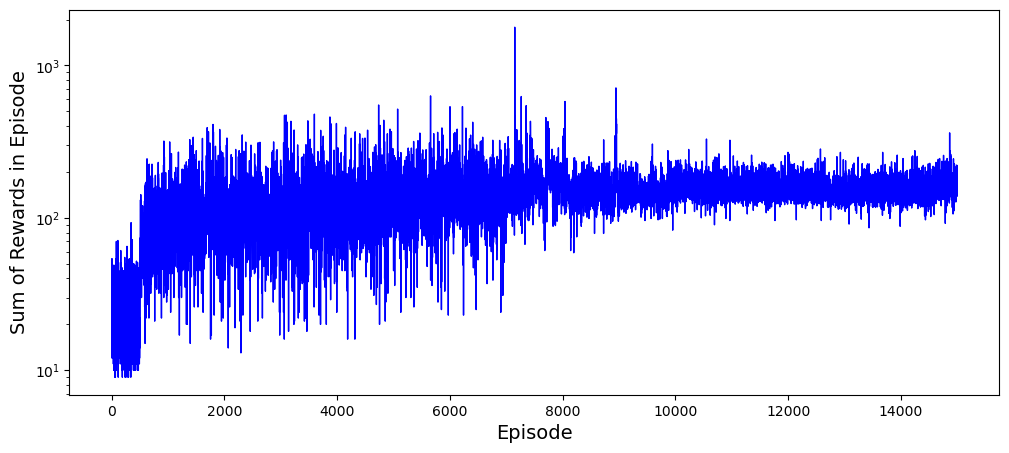

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [28]:
import gymnasium as gym
import numpy as np
import time
import matplotlib.pyplot as plt 

env=gym.make('CartPole-v1')
(state,_)=env.reset()

upperBounds=env.observation_space.high
lowerBounds=env.observation_space.low
cartVelocityMin=-3
cartVelocityMax=3
poleAngleVelocityMin=-10
poleAngleVelocityMax=10
upperBounds[1]=cartVelocityMax
upperBounds[3]=poleAngleVelocityMax
lowerBounds[1]=cartVelocityMin
lowerBounds[3]=poleAngleVelocityMin

numberOfBinsPosition=30
numberOfBinsVelocity=30
numberOfBinsAngle=30
numberOfBinsAngleVelocity=30
numberOfBins=[numberOfBinsPosition,numberOfBinsVelocity,numberOfBinsAngle,numberOfBinsAngleVelocity]

# define the parameters
alpha=0.1
gamma=1
epsilon=0.2
numberEpisodes=15000

# create an object
Q1=Q_Learning(env,alpha,gamma,epsilon,numberEpisodes,numberOfBins,lowerBounds,upperBounds)
# run the Q-Learning algorithm
Q1.simulateEpisodes()
# simulate the learned strategy
(obtainedRewardsOptimal,env1)=Q1.simulateLearnedStrategy()

plt.figure(figsize=(12, 5))
# plot the figure and adjust the plot parameters
plt.plot(Q1.sumRewardsEpisode,color='blue',linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Sum of Rewards in Episode')
plt.yscale('log')
plt.savefig('convergence.png')
plt.show()

# close the environment
env1.close()
# get the sum of rewards
np.sum(obtainedRewardsOptimal)


